<a href="https://colab.research.google.com/github/mdpatel2/MSAAI-521/blob/main/MSAAI_521_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breaking down the project

1. Take 5 images from 5 directories to make a mini dataset.
2. Using the directory names as labels, create a tfrecord file.
3. Create a dataset from the tfrecord file.
4. Display one image from the dataset.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get a mini set of images

In [39]:
import os, shutil, io
from pathlib import Path
import pandas as pd
import numpy as np
import cv2 as cv
import PIL
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow as tf

In [40]:
count = 3

In [41]:
#get full path of all kaggle subdirectories, slice first five
kaggle_dir = "/content/drive/MyDrive/kaggle/images"
kaggle_sub_dirs = next(os.walk(kaggle_dir))
kaggle_sub_paths = [os.path.join(kaggle_sub_dirs[0],kaggle_sub_dirs[1][i])for i in range(0,count)]

In [42]:
#make new dest subdirectories as dest_dir/subdir
dest_sub_dirs = kaggle_sub_dirs[1][0:count]
dest_dir = "imgs_for_dataset"
dest_sub_paths = [dest_dir + "/" + subdir for subdir in dest_sub_dirs]
for path in dest_sub_paths:
  os.makedirs(path, exist_ok=True)

In [43]:
meta_df = pd.DataFrame(columns=["filename", "label", "path"])

In [44]:
#for each kaggle image subdir
for path in kaggle_sub_paths:
  path = Path(path)
  #get the filenames and full path of images
  img_names = os.listdir(path)[0:count]
  src_paths = list(path.glob('*.jpg'))[0:count]
  #copy the image to the destination directory
  for i,src_path in enumerate(src_paths):
    new_row = {'filename': img_names[i], 'label': dest_sub_dirs[i], 'path': dest_sub_paths[i] + "/" + img_names[i]}
    meta_df = meta_df.append(new_row, ignore_index=True)
    dest_path = dest_dir + "/" + dest_sub_dirs[i] + "/" + img_names[i]
    shutil.copyfile(src_path, dest_path)

In [45]:
meta_df.head()

,filename,label,path
0,1200079.jpg,apple_pie,imgs_for_dataset/apple_pie/1200079.jpg
1,1109597.jpg,baby_back_ribs,imgs_for_dataset/baby_back_ribs/1109597.jpg
2,1038694.jpg,baklava,imgs_for_dataset/baklava/1038694.jpg
3,1106965.jpg,apple_pie,imgs_for_dataset/apple_pie/1106965.jpg
4,1098606.jpg,baby_back_ribs,imgs_for_dataset/baby_back_ribs/1098606.jpg


# Preprocessing

In [46]:
w, h = [], []
for index, row in meta_df.iterrows():
  image_orig = cv.imread(row['path'])
  w.append(image_orig.shape[0])
  h.append(image_orig.shape[0])

In [47]:
print(f"Min Width: {min(w)} Max Width {max(w)} Avg Width: {sum(w)/len(w):.2f}")
print(f"Min Height: {min(w)} Max Height {max(w)} Avg Height: {sum(w)/len(w):.2f}")

Min Width: 342 Max Width 512 Avg Width: 464.44
Min Height: 342 Max Height 512 Avg Height: 464.44


## Resizing


In [48]:
for index, row in meta_df.iterrows():
  image_orig = cv.imread(row['path'])
  image_resized = cv.resize(image_orig, dsize=(512,512))
  cv.imwrite(row['path'], image_resized)

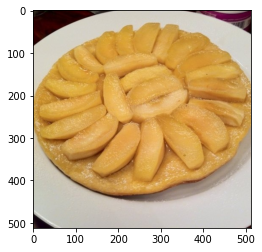

In [49]:
image_bgr = cv.imread(meta_df.iloc[0]['path'])
image_rgb = cv.cvtColor(image_bgr, cv.COLOR_BGR2RGB)
plt.imshow(image_rgb);

## Make the TFRecord file

From https://www.tensorflow.org/tutorials/load_data/tfrecord

Each record in the TFRecord file is called an *observation* or *example*. Examples are {"string": tf.train.Feature} mapping. The tf.train.Feature is a that protocol buffer message type can accept one of three types. Most other generic types can be coerced into one of these. The following are helper functions that convert integer and string features into their respective train.Feature compatible types.

In [50]:
## type conversion helper functions
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [51]:
# create example message
def image_example(image_string, label):
  feature = {
      'label': _bytes_feature(label),
      'image_raw': _bytes_feature(image_string)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

In [52]:
#iterate over the dataframe to write examples to the tfrecord file
def write_tfrecords():
  filename = "images.tfrecords"
  writer = tf.io.TFRecordWriter(filename)
  for index, row in meta_df.iterrows():
    label = str.encode(row['label'])
    image_string = open(row['path'], 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [53]:
write_tfrecords()

# Create a dataset

In [54]:
 raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Display one example

In [55]:
# Create a description of the features.
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}
def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

In [56]:
parsed_image_dataset = raw_image_dataset.map(_parse_function)

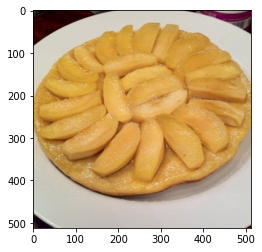

In [68]:
for image_features in parsed_image_dataset.take(1):
  image_raw = image_features['image_raw'].numpy()
  #https://stackoverflow.com/questions/49511753/python-byte-image-to-numpy-array-using-opencv
  image = np.array(PIL.Image.open(io.BytesIO(image_raw))) 
  plt.imshow(image)  

In [ ]:
mnist = keras.Sequential([
    # images are 28x28 with one color channel
    layers.Input(shape =(28, 28, 1)),
    # two convolutional layers with 32 filters
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    # max pooling / dimensional reduction
    layers.MaxPooling2D((2, 2)),
    # two convolutional layers with 64 filters
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # pooling is usually 2x2 with a stride of 2, thus (2,2)
    layers.MaxPooling2D((2, 2)),
    # flatten. the input to the neural network should be 1D
    layers.Flatten(),
    # fully connected network
    ## hidden layer with 512 nodes
    layers.Dense(512, activation='relu'),
    ## output layer. one neuron for each digit 0-9
    layers.Dense(10)
    ])

keras.utils.plot_model(mnist, show_shapes=True)

# Preprocessing

1. Resizing
2. Cropping
3. Greyscale << NO color is important
4. Normalization

## Create a CNN

1. Preprocess the images

2. Split the images into test an train
3. Create the CNN
4. Train the model

## Test train split

https://www.v7labs.com/blog/train-validation-test-set

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
view raw